In [1]:
import cv2
import os, time, pathlib, glob, io
import numpy as np
import pandas as pd
import keras
import keras.backend as K
import tensorflow as tf
import random
import skimage
from itertools import product, permutations
from matplotlib import pyplot as plt
from contextlib import redirect_stdout
from skimage.transform import resize
from sklearn.utils import shuffle
from keras import applications
from keras.models import Model, load_model
from keras.layers import Conv2D, LeakyReLU, Concatenate, Layer, InputSpec
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.python.keras.utils import conv_utils
from PIL import Image

print("All lib import")

All lib import


# Генерация данных
Загрузка данных [датасета NYU2](https://cs.nyu.edu/~silberman/datasets/nyu_depth_v2.html) с использованием путей, представленных в файлах CSV в нашем наборе данных.

Тензоры будут иметь размерность (BxHxWxC), где наши изображения - это 3-канальные массивы, а наша глубина - это одноканальные массивы.

Функции для визуализации данных:

In [2]:
def img_is_color(img):

    if len(img.shape) == 3:
        # Check the color channels to see if they're all the same.
        c1, c2, c3 = img[:, : , 0], img[:, :, 1], img[:, :, 2]
        if (c1 == c2).all() and (c2 == c3).all():
            return True

    return False

def show_image_list(list_images, list_titles=None, list_cmaps=None, grid=True, num_cols=2, figsize=(20, 10), title_fontsize=30):
    '''
    Shows a grid of images, where each image is a Numpy array. The images can be either
    RGB or grayscale.

    Parameters:
    ----------
    images: list
        List of the images to be displayed.
    list_titles: list or None
        Optional list of titles to be shown for each image.
    list_cmaps: list or None
        Optional list of cmap values for each image. If None, then cmap will be
        automatically inferred.
    grid: boolean
        If True, show a grid over each image
    num_cols: int
        Number of columns to show.
    figsize: tuple of width, height
        Value to be passed to pyplot.figure()
    title_fontsize: int
        Value to be passed to set_title().
    '''

    assert isinstance(list_images, list)
    assert len(list_images) > 0
    assert isinstance(list_images[0], np.ndarray)

    if list_titles is not None:
        assert isinstance(list_titles, list)
        assert len(list_images) == len(list_titles), '%d imgs != %d titles' % (len(list_images), len(list_titles))

    if list_cmaps is not None:
        assert isinstance(list_cmaps, list)
        assert len(list_images) == len(list_cmaps), '%d imgs != %d cmaps' % (len(list_images), len(list_cmaps))

    num_images  = len(list_images)
    num_cols    = min(num_images, num_cols)
    num_rows    = int(num_images / num_cols) + (1 if num_images % num_cols != 0 else 0)

    # Create a grid of subplots.
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    # Create list of axes for easy iteration.
    if isinstance(axes, np.ndarray):
        list_axes = list(axes.flat)
    else:
        list_axes = [axes]

    for i in range(num_images):

        img    = list_images[i]
        title  = list_titles[i] if list_titles is not None else 'Image %d' % (i)
        cmap   = list_cmaps[i] if list_cmaps is not None else (None if img_is_color(img) else 'gray')

        list_axes[i].imshow(img, cmap=cmap)
        list_axes[i].set_title(title, fontsize=title_fontsize)
        list_axes[i].grid(grid)

    for i in range(num_images, len(list_axes)):
        list_axes[i].set_visible(False)

    fig.tight_layout()
    plt.show()

# Аугментация данных
Аугументация данных путем геометрических и фотометрических преобразований является стандартной практикой для увеличения разнообразности данных в датасете, что приводит к улучшению эффективности обучения.

Для данного набора данных мы применим следующие операции:


*   Изменение цветового канала изображений
*   Зеркальное отражение изображений по горизонтали
*   Зеркальное отражение изображений по вертикали  
*   Добавление к изображениям шумов

In [3]:
class BasicPolicy(object):
    def __init__(self, mirror_ratio=0.0, flip_ratio=0.0, color_change_ratio=0.0, add_noise_peak=0.0):
        # Случайный порядок цветовых каналов
        
        self.indices = list(permutations(range(3), 3)) # Создайте несколько различных последовательностей
        self.indices.insert(0, (0, 1, 2))  # R,G,B стандартный порядок (без объединения)

        # Зеркальное отражение изображений
        self.color_change_ratio = color_change_ratio # Частота рандомизации цветовых каналов изображения
        self.mirror_ratio = mirror_ratio # Частота зеркального отражения изображений по горизонтали
        self.flip_ratio = flip_ratio # Частота зеркального отражения изображений по вертикали
        
        self.add_noise_peak = add_noise_peak # Процент шума на изображении

    def __call__(self, img, depth):
        # Убедимся, что всё float32
        img = img.astype(np.float32)
        depth = depth.astype(np.float32)

        imgo = img.copy()

        # 1) Изменение цветового канала изображений
        if random.random() < self.color_change_ratio:
            idx = random.choice(self.indices)
            img = img[..., list(idx)]

        imgc = img.copy()

        # 2) Зеркальное отражение изображений по горизонтали
        if random.random() < self.mirror_ratio:
            img = np.flip(img, axis=1)
            depth = np.flip(depth, axis=1)

        imgm = img.copy()

        # 3) Зеркальное отражение изображений по вертикали
        if random.random() < self.flip_ratio:
            img = np.flip(img, axis=0)
            depth = np.flip(depth, axis=0)

        imgf = img.copy()

        # 4) Добавление к изображениям шумов
        if self.add_noise_peak > 0:
            noisy = np.random.poisson(np.clip(img, 0, 1) * self.add_noise_peak)
            img = noisy.astype(np.float32) / self.add_noise_peak

        imgn = img.copy()

        return img, depth

    def __repr__(self):
        return "BasicPolicy"

# Загрузчик данных
Здесь мы будем использовать класс ```tensorflow.keras.utils.Sequence```, который действует, как загрузчик данных

In [4]:
class NYU_BasicAugmentRGBSequence(Sequence):
    def __init__(self, dataset, batch_size, shape_rgb, shape_depth,
                 base_path="", is_flip=False, is_addnoise=False, is_apply_policy=True, **kwargs):
        super().__init__(**kwargs)  # <-- ВАЖНО: вызов конструктора базового класса с kwargs

        self.dataset = shuffle(dataset, random_state=0)
        self.batch_size = batch_size
        self.shape_rgb = shape_rgb
        self.shape_depth = shape_depth
        self.maxDepth = 1000.0
        self.base_path = base_path
        self.is_apply_policy = is_apply_policy
        self.N = len(self.dataset)

        self.policy = BasicPolicy(
            color_change_ratio=0.50,
            mirror_ratio=0.50,
            flip_ratio=0.0 if not is_flip else 0.2,
            add_noise_peak=0 if not is_addnoise else 20
        )

    def __len__(self):
        return int(np.ceil(self.N / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_rgb = np.zeros((self.batch_size, *self.shape_rgb), dtype=np.float32)
        batch_depth = np.zeros((self.batch_size, *self.shape_depth), dtype=np.float32)

        for i in range(self.batch_size):
            index = min((idx * self.batch_size) + i, self.N - 1)
            rgb_rel, depth_rel = self.dataset[index]

            rgb_path = os.path.join(self.base_path, rgb_rel)
            depth_path = os.path.join(self.base_path, depth_rel)

            try:
                x = np.array(Image.open(rgb_path)).astype(np.float32) / 255.0
                y = np.array(Image.open(depth_path)).astype(np.float32) / 255.0 * self.maxDepth

                y = self.maxDepth / (y + 1e-6)

                if x.ndim == 2:  # если grayscale
                    x = np.stack([x]*3, axis=-1)

                x = resize(x, self.shape_rgb[:2], preserve_range=True, mode='reflect', anti_aliasing=True)
                y = resize(y.reshape(y.shape[0], y.shape[1], 1), self.shape_depth[:2],
                       preserve_range=True, mode='reflect', anti_aliasing=True)

                if self.is_apply_policy:
                    x, y = self.policy(x, y)

                batch_rgb[i] = x
                batch_depth[i] = y

            except Exception as e:
                print(f"[Ошибка] Не удалось загрузить {rgb_path} или {depth_path}: {e}")
                continue

        return batch_rgb, batch_depth

In [5]:
# Размеры изображений
shape_rgb = (480, 640, 3)
shape_depth = (240, 320, 1)

# Размер батча
batch_size = 8

# Базовый путь
base_path = "/kaggle/input/nyu-depth-v2/nyu_data";

# Пути к CSV
csv_train = "/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_train.csv"
csv_test = "/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_test.csv"

In [6]:
df_train = pd.read_csv(csv_train)
df_test = pd.read_csv(csv_test)

assert df_train.shape[1] >= 2, "В train CSV должно быть как минимум 2 колонки"
assert df_test.shape[1] >= 2, "В test CSV должно быть как минимум 2 колонки"

nyu2_train = list(zip(df_train.iloc[:, 0], df_train.iloc[:, 1]))
nyu2_test = list(zip(df_test.iloc[:, 0], df_test.iloc[:, 1]))

In [7]:
reduced_dataset = nyu2_train[:len(nyu2_train) // 4]

train_generator = NYU_BasicAugmentRGBSequence(
    dataset=reduced_dataset,
    batch_size=batch_size,
    shape_rgb=shape_rgb,
    shape_depth=shape_depth,
    base_path=base_path,
    is_apply_policy=True
)
print(f"Количество изображений в train генераторе: {len(train_generator.dataset)}")

val_generator = NYU_BasicAugmentRGBSequence(
    dataset=nyu2_test,
    batch_size=batch_size,
    shape_rgb=shape_rgb,
    shape_depth=shape_depth,
    base_path=base_path,
    is_apply_policy=False
)
print(f"Количество изображений в valid генераторе: {len(val_generator.dataset)}")

Количество изображений в train генераторе: 12671
Количество изображений в valid генераторе: 653


In [8]:
def load_test_data_from_csv(csv_path, base_path, shape_rgb=(480, 640, 3), shape_depth=(240, 320, 1)):
    df = pd.read_csv(csv_path, header=None)
    rgb_list = []
    depth_list = []
    crop_list = []

    for _, row in df.iterrows():
        rgb_path = os.path.join(base_path, row[0])
        depth_path = os.path.join(base_path, row[1])

        # Чтение RGB
        rgb_img = cv2.imread(rgb_path)
        rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)
        rgb_img = cv2.resize(rgb_img, (shape_rgb[1], shape_rgb[0])) / 255.0
        rgb_list.append(rgb_img)

        # Чтение Depth
        depth_img = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)
        depth_img = cv2.resize(depth_img, (shape_depth[1], shape_depth[0]))
        if len(depth_img.shape) == 3:
            depth_img = cv2.cvtColor(depth_img, cv2.COLOR_BGR2GRAY)
        depth_img = np.expand_dims(depth_img, axis=-1)
        depth_list.append(depth_img)

        # Crop-заглушка
        crop_list.append([0, 0, shape_depth[0], shape_depth[1]])

    return {
        'rgb': np.array(rgb_list, dtype=np.float32),
        'depth': np.array(depth_list, dtype=np.float32),
        'crop': np.array(crop_list, dtype=np.int32)
    }

test_set = load_test_data_from_csv(
    csv_path=csv_test,
    base_path=base_path,
    shape_rgb=shape_rgb,
    shape_depth=shape_depth
)

print(f"Количество изображений в тестовом наборе: {len(test_set['rgb'])}")

Количество изображений в тестовом наборе: 654


Вывести элемент train_generator

RGB batch shape: (8, 480, 640, 3)
Depth batch shape: (8, 240, 320, 1)


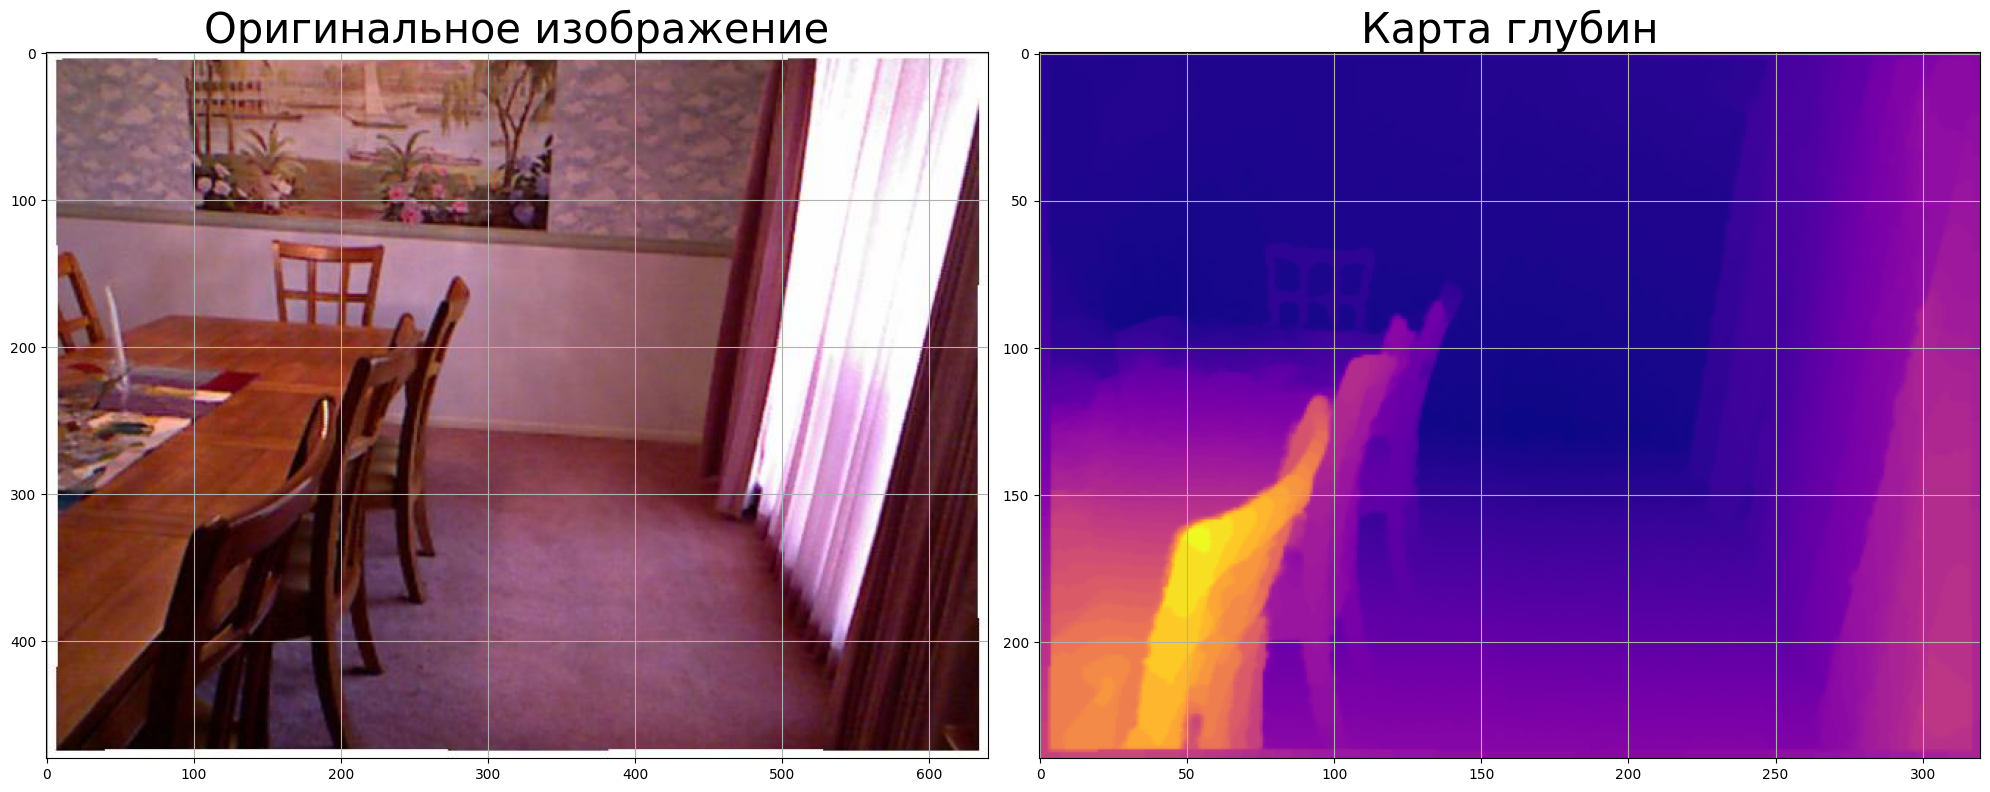

In [9]:
rgb_batch, depth_batch = train_generator[0]

print("RGB batch shape:", rgb_batch.shape)
print("Depth batch shape:", depth_batch.shape)

rgb_np = rgb_batch[0]
depth_np = depth_batch[0, :, :, 0]

show_image_list(
    [rgb_np, depth_np],
    list_titles=["Оригинальное изображение", "Карта глубин"],
    list_cmaps=[None, "plasma"]
)

# Предварительный просмотр набора данных
Показать часть набора данных, содержащую RGB и соответствующие им карты глубины

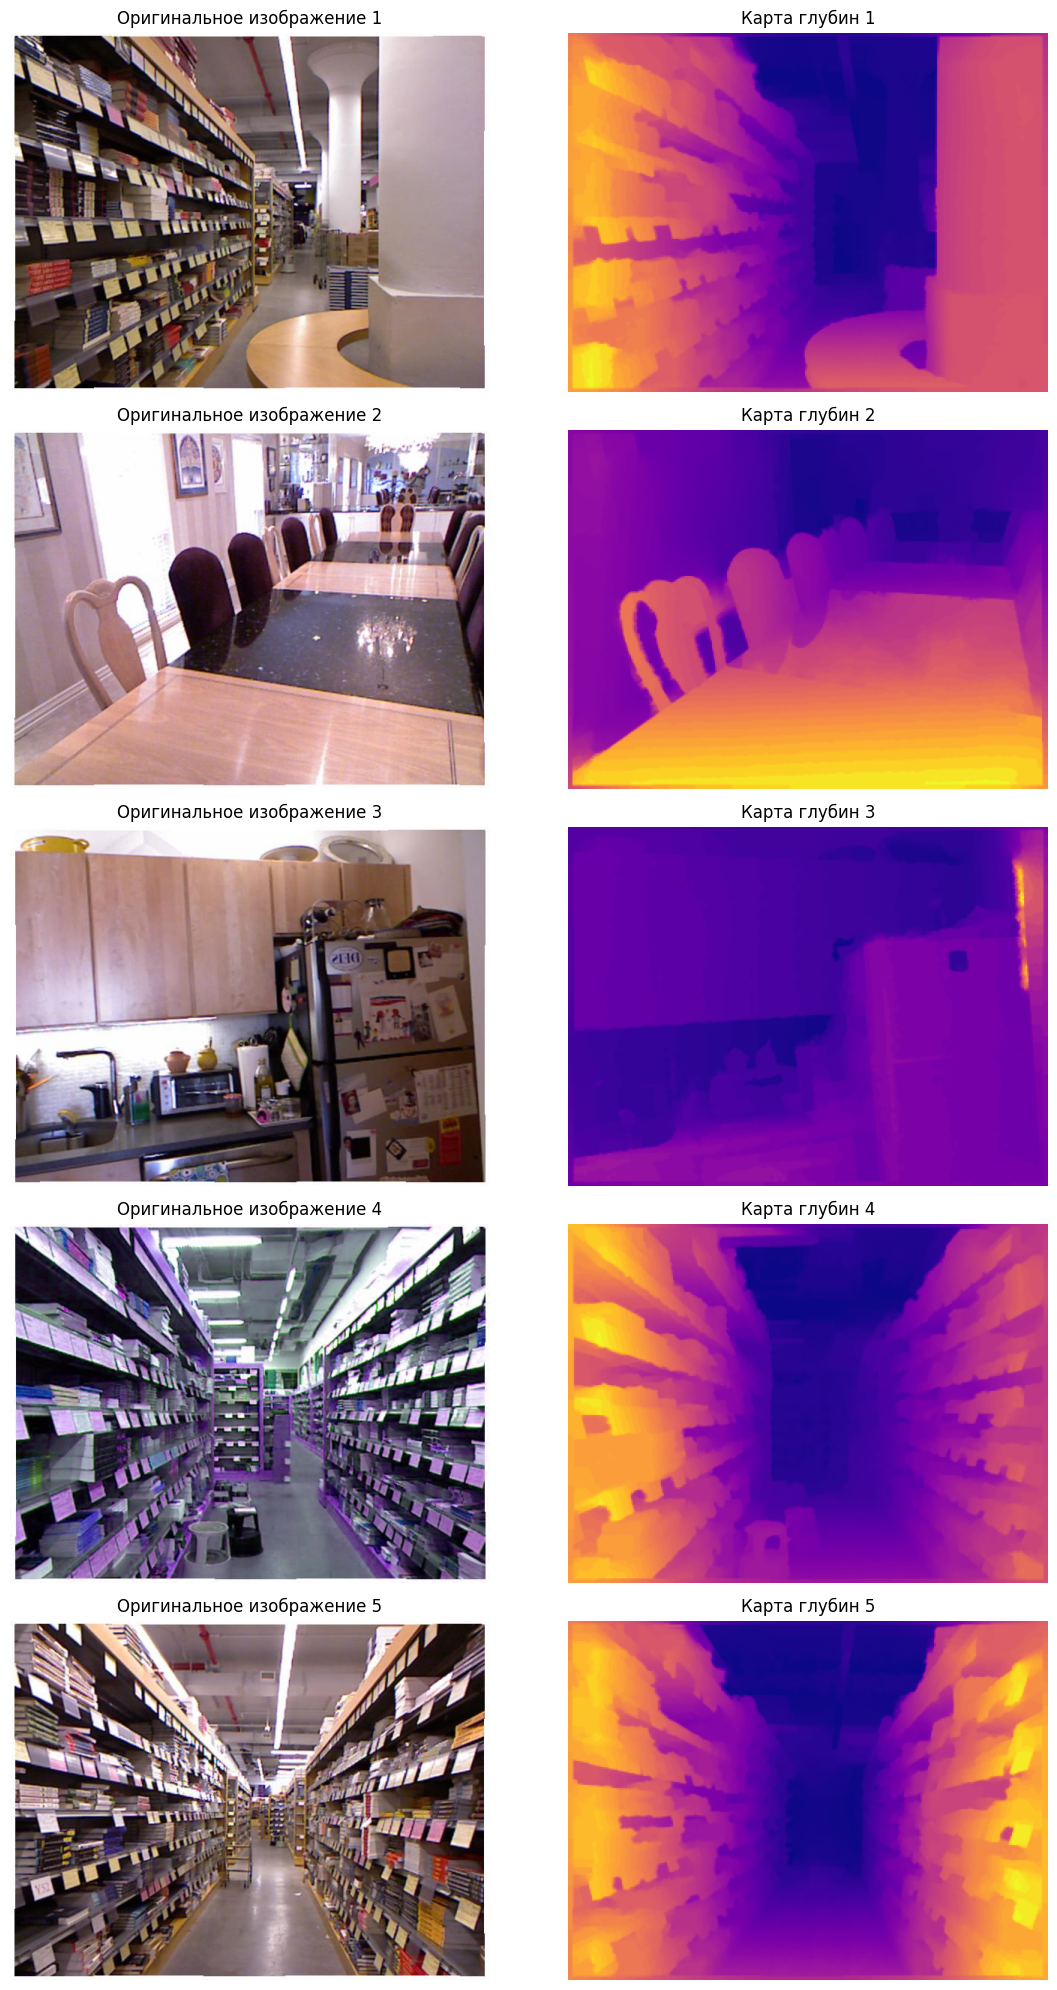

In [10]:
rgb_batch, depth_batch = train_generator[1]

num_samples = min(5, rgb_batch.shape[0])

plt.figure(figsize=(12, 4 * num_samples))

for i in range(num_samples):
    rgb = rgb_batch[i]  # (H, W, 3)
    depth = depth_batch[i, :, :, 0]  # (H, W)

    depth_vis = depth / (depth.max() + 1e-8)

    plt.subplot(num_samples, 2, 2 * i + 1)
    plt.imshow(np.clip(rgb, 0, 1))
    plt.title(f"Оригинальное изображение {i + 1}")
    plt.axis('off')

    plt.subplot(num_samples, 2, 2 * i + 2)
    plt.imshow(depth_vis, cmap='plasma')
    plt.title(f"Карта глубин {i + 1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Построить модель

Эта модель представляет собой сеть кодировщика-декодировщика для оценки глубины.
Для кодировщика входное RGB-изображение кодируется в вектор признаков, используя модель с [архитектурой DenseNet-169](https://ieeexplore.ieee.org/document/8099726) предобученную на [ImageNet](https://image-net.org/about.php).

Декодер, сформированный из этих слоев, последовательно :

1.   Слой свертки 1 × 1 для выхода кодировщика с количеством признаков, равным количеству признаков в конечном слое кодировщика.
2.   Четыре непрерывных **блока апсемплинга** с соответствующими пропускными связями.
3.   Слой свертки 3 × 3 для выхода кодировщика с числом признаков, равным 1.

Каждый блок апсемплинга содержит следующие слои:
1. Билинейный апсемплинг 2 × 2
2. Слой конкантенации со слоями из кодировщика
3. Слой свертки 3 × 3 с числом признаков, равным половине блока признаков предыдущего входа.
4. Еще один слой свертки 3 × 3 с числом признаков, равным половине блока признаков предыдущего входа


На следующем рисунке представлена архитектура сети:

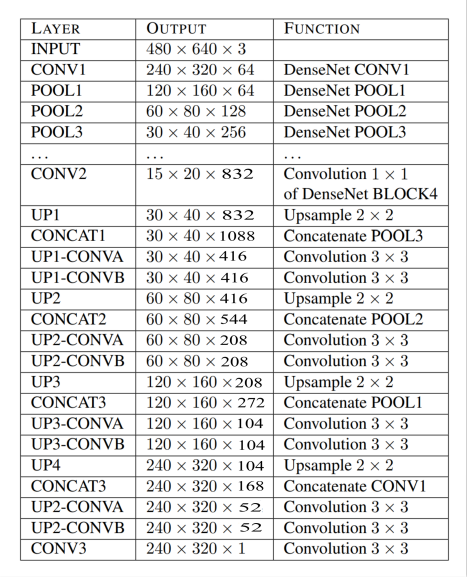

Названия важных слоёв энкодера, которые предстоит использовать:

'pool3_pool'

'pool2_pool'

'pool'

'conv1/relu'

In [11]:
class BilinearUpSampling2D(Layer):
    def __init__(self, size=(2, 2), data_format=None, **kwargs):
        super(BilinearUpSampling2D, self).__init__(**kwargs)  # <-- fixed here
        if data_format is None:
            data_format = K.image_data_format()
        self.data_format = data_format.lower()
        self.size = conv_utils.normalize_tuple(size, 2, 'size')
        self.input_spec = InputSpec(ndim=4)

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_first':
            height = self.size[0] * input_shape[2] if input_shape[2] is not None else None
            width = self.size[1] * input_shape[3] if input_shape[3] is not None else None
            return (input_shape[0],input_shape[1],height,width)
        elif self.data_format == 'channels_last':
            height = self.size[0] * input_shape[1] if input_shape[1] is not None else None
            width = self.size[1] * input_shape[2] if input_shape[2] is not None else None
            return (input_shape[0],height,width,input_shape[3])

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        if self.data_format == 'channels_first':
            height = self.size[0] * input_shape[2] if input_shape[2] is not None else None
            width = self.size[1] * input_shape[3] if input_shape[3] is not None else None
        elif self.data_format == 'channels_last':
            height = self.size[0] * input_shape[1] if input_shape[1] is not None else None
            width = self.size[1] * input_shape[2] if input_shape[2] is not None else None

        return tf.image.resize(inputs, [height, width], method=tf.image.ResizeMethod.BILINEAR)

    def get_config(self):
        config = {'size': self.size, 'data_format': self.data_format}
        base_config = super(BilinearUpSampling2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def create_model():
        print('Loading base model (DenseNet)..')
        # Слои кодировщика

        base_model = applications.DenseNet169(input_shape=(None, None, 3), include_top=False, weights=None)

        print('Base model loaded.')

        # Начальная точка для декодера
        base_model_output_shape = base_model.layers[-1].output.shape

        # Сделать слои доступными к обучению?
        for layer in base_model.layers: layer.trainable = True

        # Начальное количество фильтров декодера

        decode_filters = int(int(base_model_output_shape[-1]) / 2)

        # Функция блока апсемплинга
        def upproject(tensor, filters, name, concat_with):
            up_i = BilinearUpSampling2D((2, 2), name=name + '_upsampling2d')(tensor)
            up_i = Concatenate(name=name + '_concat')([up_i, base_model.get_layer(concat_with).output])  # Skip connection
            up_i = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same', name=name + '_convA')(up_i)
            up_i = LeakyReLU(negative_slope=0.2)(up_i)
            up_i = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same', name=name + '_convB')(up_i)
            up_i = LeakyReLU(negative_slope=0.2)(up_i)
            return up_i

        #######################################################
        # Написать здесь структуру декодировщика в соответствии с таблицей
                # Сжимаем выход DenseNet до 832 каналов (CONV2)
        x = Conv2D(832, kernel_size=1, padding='same', name='conv2_reduce')(base_model.output)

        # UP1 → POOL3
        x = upproject(x, filters=416, name='up1', concat_with='pool3_pool')

        # UP2 → POOL2
        x = upproject(x, filters=208, name='up2', concat_with='pool2_pool')

        # UP3 → POOL1
        x = upproject(x, filters=104, name='up3', concat_with='pool1')

        # UP4 → CONV1
        x = upproject(x, filters=52, name='up4', concat_with='conv1_relu')

        # Финальный слой — свёртка в 1 канал (depth map)
        conv3 = Conv2D(1, kernel_size=3, padding='same', name='conv3')(x)
        #######################################################

        # Создание модели
        model = Model(inputs=base_model.input, outputs=conv3)
    
        print('Model created.')

        return model

# Выполнение построения модели
model = create_model()

Loading base model (DenseNet)..
Base model loaded.
Model created.


# Определение гиперпараметров

In [12]:
# === Гиперпараметры ===
learning_rate = 5e-4      # скорость обучения
epochs = 1              # количество эпох

# Местоположение выгрузки журналов модели и контрольных точек (весов)
runID = str(int(time.time())) + '-n' + str(batch_size) + '-e' + str(epochs) + '-bs' + str(batch_size) + '-lr' + str(learning_rate)
outputPath = '/kaggle/working/'
runPath = outputPath + runID
pathlib.Path(runPath).mkdir(parents=True, exist_ok=True)
print('Output: ' + runPath)

Output: /kaggle/working/1744453305-n8-e1-bs8-lr0.0005


# Функция потерь
Общая функция потерь может быть представлена в следующем виде:
$$L(y, \hat{y})=\lambda L_{\text {depth }}(y, \hat{y})+L_{\text {grad }}(y, \hat{y})+L_{S S I M}(y, \hat{y})$$

Эта функция потерь состоит из трех компонентов:


*   $L_{depth}$ это $L_1$ потери, определяемые по значениям глубины



$$
L_{\text {depth }}(y, \hat{y})=\frac{1}{n} \sum_{p}^{n}\left|y_{p}-\hat{y}_{p}\right|
$$

*   $L_{grad}$ это $L_1$ потери, определенные по градиентам $g$ изображения  глубины

$$
L_{g r a d}(y, \hat{y})=\frac{1}{n} \sum_{p}^{n}\left|\boldsymbol{g}_{\mathbf{x}}\left(y_{p}, \hat{y}_{p}\right)\right|+\left|\boldsymbol{g}_{\mathbf{y}}\left(y_{p}, \hat{y}_{p}\right)\right|
$$

* $L_{SSIM}$ использует метрику структурного сходства (SSIM), которая широко используется для задач реконструкции изображений

$$
L_{S S I M}(y, \hat{y}) = \frac{1  - L_{S S I M}(y, \hat{y}) }{2}
$$

In [13]:
def depth_loss_function(y_true, y_pred, theta=0.1, maxDepthVal=1000.0 / 10.0):
    # Написать здесь три функции потерь l_depth, l_edges, l_ssim

    y_true_resized = tf.image.resize(y_true, tf.shape(y_pred)[1:3], method='bilinear')
    
    l_depth = tf.reduce_mean(tf.abs(y_pred - y_true_resized), axis=-1)
    
    dy_true, dx_true = tf.image.image_gradients(y_true_resized)
    dy_pred, dx_pred = tf.image.image_gradients(y_pred)
    l_edges = tf.reduce_mean(tf.abs(dx_pred - dx_true) + tf.abs(dy_pred - dy_true), axis=-1)
    
    l_ssim = tf.clip_by_value((1 - tf.image.ssim(y_true_resized, y_pred, maxDepthVal)) / 2, 0, 1)

    # Веса
    w1 = 1.0
    w2 = 1.0
    w3 = theta
    
    return (w1 * l_ssim) + (w2 * tf.reduce_mean(l_edges)) + (w3 * tf.reduce_mean(l_depth))

# Метрики точности
Существует несколько показателей, которые отражают точность задачи оценки глубины:


*   Средняя относительная ошибка

$$\frac{1}{n} \sum_{p}^{n} \frac{\left|y_{p}-\hat{y}_{p}\right|}{y_{p}}$$

*   Корневая средняя квадратичная ошибка

  $$ \sqrt{\left.\frac{1}{n} \sum_{p}^{n}\left(y_{p}-\hat{y}_{p}\right)^{2}\right)}$$

* Средняя ошибка $log _{10}$

  $$\frac{1}{n} \sum_{p}^{n}\left|\log _{10}\left(y_{p}\right)-\log _{10}\left(\hat{y}_{p}\right)\right|$$
  
* Пороговая точность в процентах (%) $\delta_{i}$ от $y_{p}$ так, что

  $$\max \left(\frac{y_{p}}{\hat{y}_{p}}, \frac{\hat{y}_{p}}{y_{p}}\right)=\delta<\operatorname{thr} for \operatorname{thr}=1.25,1.25^{2}, 1.25^{3}
$$

In [14]:
def compute_errors(y_pred, y_true):
    # Написать здесь функции представленных выше метрик точности
    
    res = tf.max(y_true / y_pred, y_pred / y_true)
    a1 = tf.mean(res < 1.25) * 100
    a2 = tf.mean(res < 1.25 ** 2) * 100
    a3 = tf.mean(res < 1.25 ** 3) * 100

    abs_rel = tf.abs(y_true - y_pred) / y_true
    rmse = tf.sqrt((y_true - y_pred) ** 2)
    log_10 = tf.log10(y_true) - tf.log10(y_pred)
    
    return a1, a2, a3, abs_rel, rmse, log_10

# Обучение сети
Пайплайн обучения и оценки

### Функции предварительной обработки
Применить батч RGB-изображений  к сети

In [15]:
def predict(model, images, minDepth=10, maxDepth=1000, batch_size=2):
    # Поддержка нескольких RGB, одного RGB изображения или изображений в градациях серого цвета
    if len(images.shape) < 3: images = np.stack((images,images,images), axis=2)
    if len(images.shape) < 4: images = images.reshape((1, images.shape[0], images.shape[1], images.shape[2]))
    # Вычисление прогнозов
    predictions = model.predict(images, batch_size=batch_size)   # Модель в Keras имеет встроенную функцию model.predict()
    # Вывод в ожидаемом диапазоне
    return np.clip(maxDepth / predictions, minDepth, maxDepth) / maxDepth

### Функция оценки
Создание функций для организации процесса оценки на основе показателей точности с использованием тестового набора данных

In [16]:
def scale_up(scale, images):
    scaled = []
    for i in range(len(images)):
        img = images[i]
        output_shape = (scale * img.shape[0], scale * img.shape[1])
        scaled.append(resize(img, output_shape, order=1, preserve_range=True, mode='reflect', anti_aliasing=True))
    return np.stack(scaled)

def evaluate(model, rgb, depth, crop, batch_size):
    N = len(rgb)

    bs = batch_size

    predictions = []
    testSetDepths = []

    for i in range(N // bs):
        x = rgb[(i) * bs:(i + 1) * bs, :, :, :]

        # Вычислить результаты
        true_y = depth[(i) * bs:(i + 1) * bs, :, :]
        pred_y = scale_up(2, predict(model, x / 255, minDepth=10, maxDepth=1000, batch_size=bs)[:, :, :, 0]) * 10.0

        # Кадрирование изображений
        true_y = true_y[:, crop[0]:crop[1] + 1, crop[2]:crop[3] + 1]
        pred_y = pred_y[:, crop[0]:crop[1] + 1, crop[2]:crop[3] + 1]

        # Вычисление ошибок для каждого изображения в батче
        for j in range(len(true_y)):
            predictions.append(pred_y[j])
            testSetDepths.append(true_y[j])

    predictions = np.stack(predictions, axis=0)
    testSetDepths = np.stack(testSetDepths, axis=0)

    e = compute_errors(predictions, testSetDepths)

    print("{:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}".format('a1', 'a2', 'a3', 'rel', 'rms', 'log_10'))
    print("{:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}".format(e[0], e[1], e[2], e[3], e[4], e[5]))
    return e

### Процесс обучения

Генерация обратных вызовов по окончании каждой эпохи

In [17]:
def get_nyu_callbacks(model, train_generator, val_generator, test_set, runPath, do_eval, batch_size):
    callbacks = []

    # Обратный вызов: Tensorboard
    class LRTensorBoard(tf.keras.callbacks.TensorBoard):
        def __init__(self, log_dir):
            super().__init__(log_dir=log_dir)
            self.writer = tf.summary.create_file_writer(log_dir)

        def on_epoch_end(self, epoch, logs=None):
            super().on_epoch_end(epoch, logs)

            # Вычисление метрик по завершении каждой эпохи
            if do_eval:
                e = evaluate(model, test_set['rgb'], test_set['depth'], test_set['crop'], batch_size)
                a1, a2, a3, rel, rms, log10 = e

                # Напишите здесь  собственный автор метрик точности в Tensorboard
                with self.writer.as_default():
                    tf.summary.scalar('eval/a1', a1, step=epoch)
                    tf.summary.scalar('eval/a2', a2, step=epoch)
                    tf.summary.scalar('eval/a3', a3, step=epoch)
                    tf.summary.scalar('eval/rel', rel, step=epoch)
                    tf.summary.scalar('eval/rms', rms, step=epoch)
                    tf.summary.scalar('eval/log_10', log10, step=epoch)
                    self.writer.flush()

    callbacks.append(LRTensorBoard(log_dir=runPath))

    # Обратный вызов: Планировщик скорости обучения
    lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=5, min_lr=9e-5, min_delta=1e-2, verbose=1)
    callbacks.append(lr_schedule) # снижать скорость обучения при проблемах

    return callbacks

In [18]:
import tensorflow as tf
print("Доступные устройства:", tf.config.list_physical_devices('GPU'))

Доступные устройства: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [19]:
optimizer = Adam(learning_rate=learning_rate, amsgrad=True)

model.compile(loss=depth_loss_function, optimizer=optimizer)  # Применение оптимизатора и функции потерь

callbacks = get_nyu_callbacks(model, train_generator, val_generator, test_set, runPath,do_eval=False, batch_size=batch_size) # Создание обратных вызовов

with tf.device('/GPU:0'):
    history = model.fit(train_generator, callbacks=callbacks, validation_data=val_generator, epochs=epochs, shuffle=True)  # Начало процесса обучения

1584/1584 ━━━━━━━━━━━━━━━━━━━━ 1872s 893ms/step - loss: 0.3105 - val_loss: 0.8335 - learning_rate: 5.0000e-04


In [25]:
model.save_weights('/kaggle/working/my_checkpoint.weights.h5')

# Вывод на основе обученной модели

In [30]:
history.history

{'loss': [0.27019354701042175],
 'val_loss': [0.8334940671920776],
 'learning_rate': [0.0005000000237487257]}

In [21]:
def visualize_predictions(model, test_set, num_examples=5):
    rgb = test_set['rgb']
    true_depth = test_set['depth']
    
    preds = model.predict(rgb, batch_size=1)
    
    for i in range(num_examples):
        fig, axs = plt.subplots(1, 2, figsize=(20, 5))
        
        axs[0].imshow(rgb[i])
        axs[0].set_title(f"Оригинальное изображение {i + 1}")
        axs[0].axis('off')
        
        axs[1].imshow(preds[i].squeeze(), cmap='plasma')
        axs[1].set_title(f"Карта глубин {i + 1}")
        axs[1].axis('off')
       
        plt.tight_layout()
        plt.show()

654/654 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step


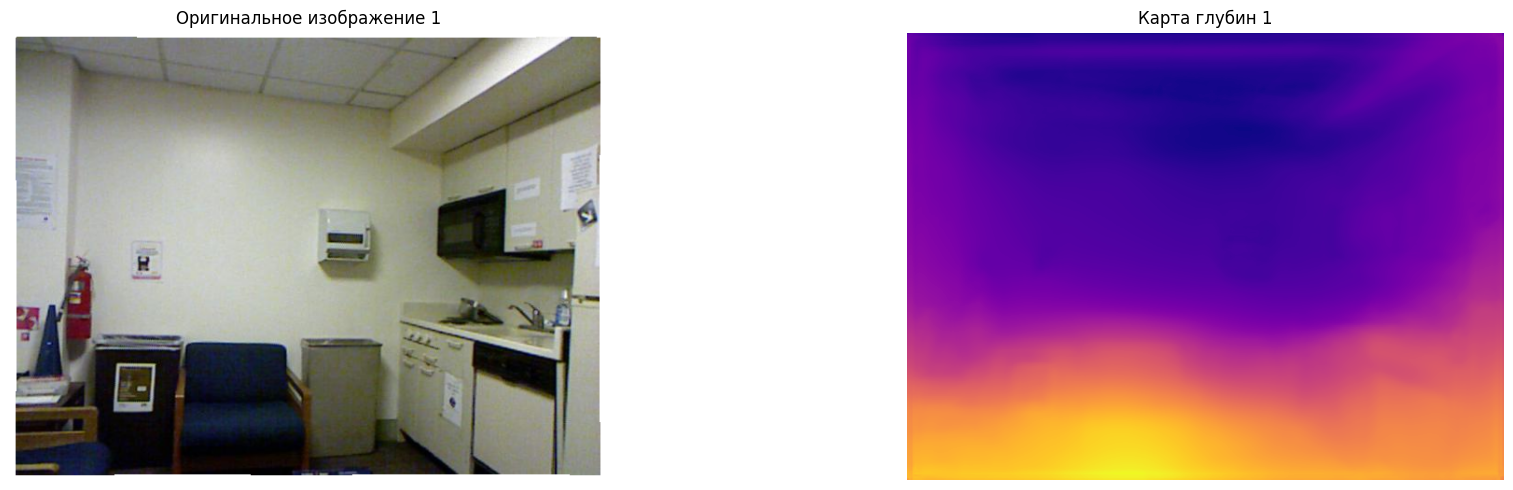

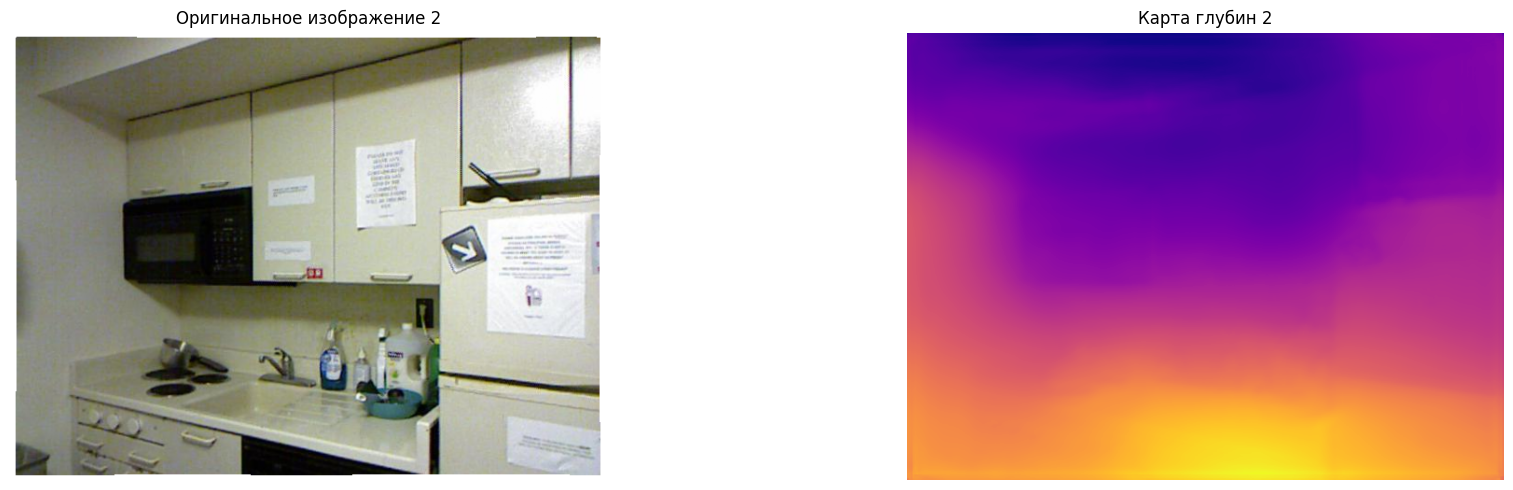

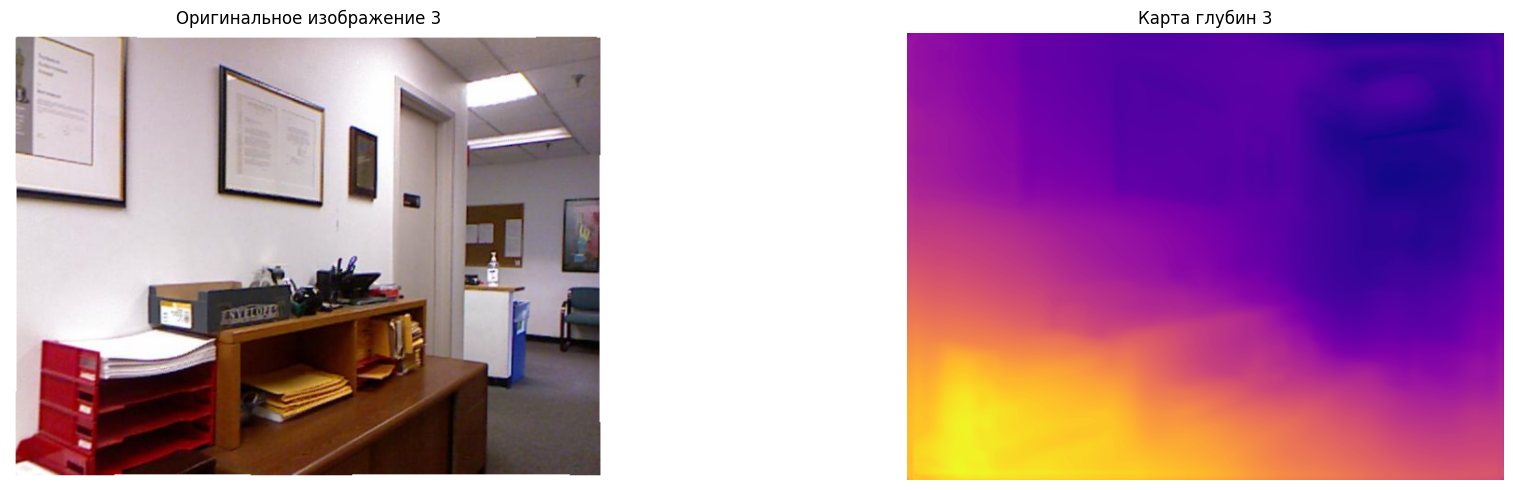

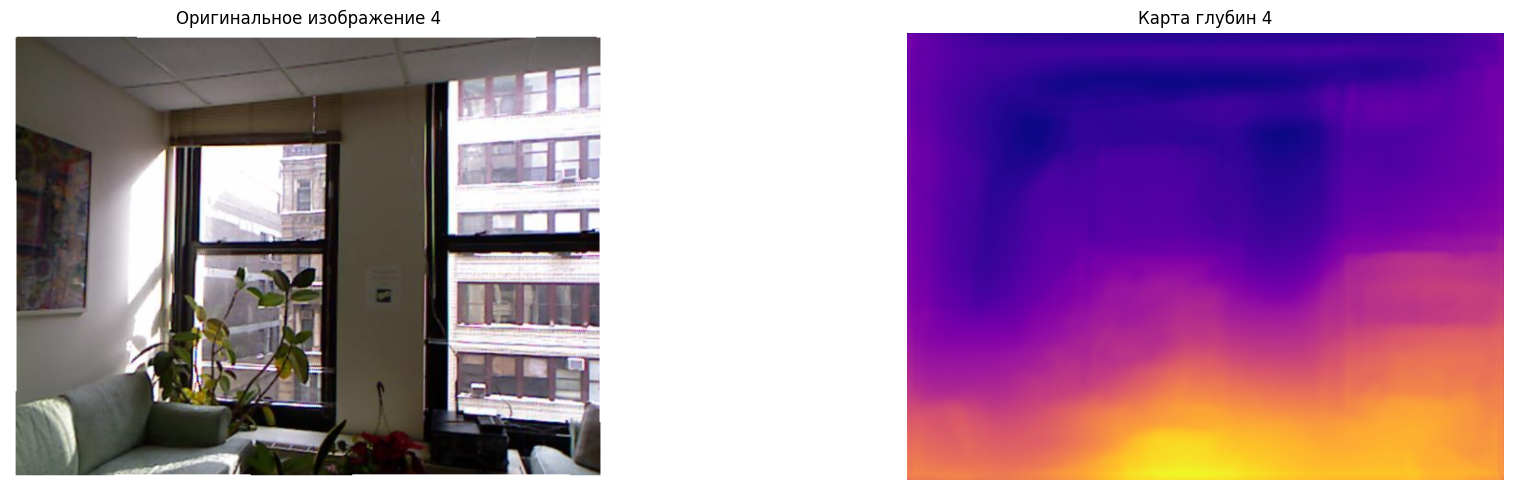

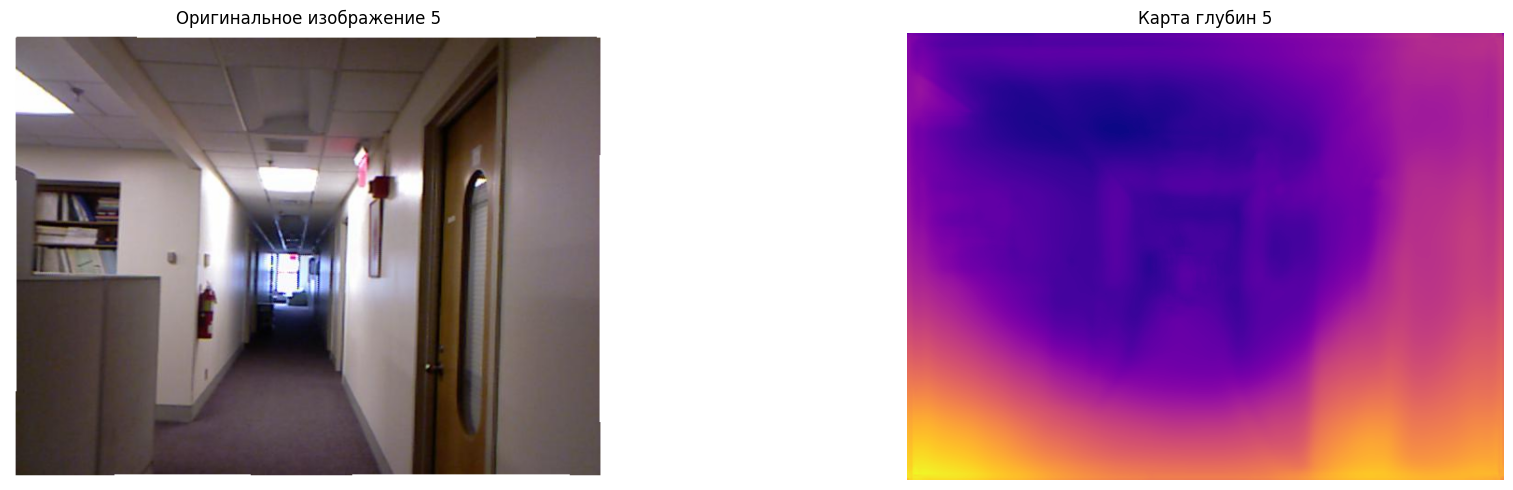

In [22]:
visualize_predictions(model, test_set)